# 4.2 Реализация генетического алгоритма
Реализовать генетический алгоритм решения задачи о рюкзаке, используя свой набор генетических операторов (определяется номером в списке и другими параметрами), и получить результаты на своем наборе данных (определяется номером в списке).

Шергалис Донат, 3530903/70301 Вариант 31.

In [1]:
var = 31
population_size = 200

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import json
from operator import itemgetter 
from geneticalgorithm import geneticalgorithm as ga

In [3]:
def read_file(var = var):
    data_file = 'data/' + str(var) + '.txt'

    with open(data_file) as f:
        W, V = [int(x) for x in next(f).split()]

    data = pd.read_csv(data_file, 
                       skiprows=1,  
                       names=['w', 'v', 'c'], 
                       delim_whitespace=True)
    return data, W, V

In [4]:
data, W, V = read_file(var)
weights = len(data.index)

print(f'weights = {weights}') # количество весов
print(f'W = {W}') # грузоподъёмность
print(f'V = {V}') # вместимость

print('data: ')   # w = вес, v = объём, c = ценность
data.head()

weights = 30
W = 13000
V = 12
data: 


,w,v,c
0,897,0.6,167
1,138,0.6,293
2,1569,0.8,359
3,672,0.7,298
4,1514,0.4,265


In [5]:
def sum_col(solution, col):
    return round(sum(data[col][i] if s else 0 for i, s in enumerate(solution)), 5)

def sums(solution):
    return [sum_col(solution, col) for col in ['w', 'v', 'c']]

In [6]:
def valid(w, v):
    return w <= W and v <= V

In [7]:
def fitness(solution):
    w, v, c = sums(solution)
    return c if valid(w, v) \
            else 0 # c - 5 * (min(W - w, 0) - min(V - v, 0))

In [8]:
def sort_solutions(solutions):
    sorted = list(solutions)
    sorted.sort(key=fitness, reverse=True)
    return sorted

In [9]:
def w(i):
    return data['w'][i]

def v(i):
    return data['v'][i]

def c(i):
    return data['c'][i]

In [10]:
def to_str(solution):
    return '[' + ''.join(['#' if i else ' ' for i in solution]) + ']'

# Условия

## 0. Кодирование – выбор «генетического кода»  
  Особь – битовая последовательность размера n (кол-во грузов)  

## 1. Начальная популяция – кол-во особей всегда = 200:  
  1.1 случайная генерация  
  1.2 **жадный выбор, начиная со случайного груза**  

In [11]:
def random_solution():
    start = random.randint(0, weights - 1)
    end = start
    
    sumW = w(start)
    sumV = v(start)
    while end + 1 < weights \
            and sumW + w(end + 1) <= W \
            and sumV + v(end + 1) <= V:
        end += 1
        sumW = round(sumW + w(end), 5)
        sumV = round(sumV + v(end), 5)
    
    return [True if start <= i and i <= end else False for i in range(0, weights - 1)]

In [12]:
population = [random_solution() for i in range(0, population_size)]

# demonstration
for s in population[:10]:
    print(to_str(s)) 

[             ############    ]
[                      #######]
[               ############  ]
[       ##########            ]
[   ##########                ]
[##########                   ]
[          ############       ]
[                          ###]
[                ############ ]
[                            #]



## 2. Отбор особей для скрещивания:  
  2.1 выбор каждой особи пропорционально приспособленности (рулетка)  
  2.2 **выбрать только 20% самых приспособленных особей**  


In [13]:
def divide(solutions):
    sorted = sort_solutions(solutions)
    remains = round(len(solutions) / 5)
    # top, middle, trash
    return sorted[:remains], \
            sorted[remains:-remains], \
            sorted[-remains:]

## 3. Скрещивание (кроссинговер) между выбранными особями. 
Каждая особь скрещивается 1 раз за 1 поколение, 1 пара дает 2 потомка:   
  3.1 **многоточечный с 3мя точками**  
  3.2 однородный (каждый бит от случайно выбранного родителя)  

In [14]:

def intercourse(solution1, solution2):
    randomlist = random.sample(range(0, len(solution1)), 3)
    randomlist.sort()
    p1, p2, p3 = randomlist
    matrix = [True] * p1 \
            + [False] * (p2 - p1) \
            + [True] * (p3 - p2) \
            + [False] * (len(solution1) - p3)
    
    zipped = list(zip(matrix, solution1, solution2))
    
    c1 = [s1 if     w else s2 for w, s1, s2 in zipped]
    c2 = [s1 if not w else s2 for w, s1, s2 in zipped]
    
    return c1, c2


## 4. Мутация:  
  4.1 **инвертирование всех битов у 1 особи**  
  4.2 случайное изменение 3х битов у 5% особей  
  4.3 добавление 1 случайной вещи 5% особей  

In [15]:
def mutate(solutions):
    for i in range(0, 50): # несколько раз пробуем, может не получиться
        r = random.randint(0, len(solutions) - 1)
        mutant = [not s for s in solutions[r]]
        if fitness(mutant) > 0:
            solutions[r] = mutant
            return

## 5. Формирование новой популяции (кол-во особей - константа)  
  5.1 замена 20% худших особей из предыдущего поколения на лучших потомков  
  5.2 «штраф» за «старость» - 10% функции приспособленности, выбор лучших  
  5.3 **замена своих родителей**  

In [16]:
def make_children(alfas):
    children = []
    alfas = list(alfas)
    random.shuffle(alfas)
    while len(alfas) >= 2:
        children += intercourse(alfas.pop(), alfas.pop())
    return children

In [17]:
def new_gen(solutions):
    alfas, incels, trash = divide(solutions)
    # new_gen = alfas + make_children(alfas) + incels
    new_gen = make_children(alfas) + incels + trash
    mutate(new_gen)
    return new_gen

## 6. Оценка результата  
Наступила сходимость (функция приспособленности лучшей особи в популяциях отличается не более, чем на стоимость самой дешевой вещи) или прошло 500 поколений

In [18]:
min_price = min(data['c'])

def enough(gen, population, the_best):
    sorted = sort_solutions(population)
    best = sorted[0]
    
    print(gen, fitness(best), to_str(best))
    
    is_enough = gen >= 100 #or abs(the_best) - abs(best) <= min_price
    the_best = select_the_best(best, the_best)

    return is_enough, the_best

In [19]:
def select_the_best(best, the_best):
    best_fitnesses.append(fitness(best))
    return best if fitness(best) > fitness(the_best) else the_best

 ## Алгоритм итерирования
 1. Начальная популяция - `random_solution()`
 2. Отбор - `divide()`
 3. Скрещивание - `intercourse()`
 4. Мутация - `mutate()`
 5. Новая популяция - `new_gen()`
 6. Если результат не достигнут, перейти к п.2 - `enough()`
 7. Результирующая популяция - `result_gen`, лучшее решение `the_best`
 

In [20]:
best_fitnesses = []

def iterate(population, gen = 0, the_best = population[0]):
    assert len(population) == population_size
    
    is_enough, the_best = enough(gen, population, the_best)

    if is_enough:
        return population, the_best
    else:
        return iterate(new_gen(population), gen + 1, the_best)

result_gen, the_best = iterate(population)
print()

0 3557 [           #############     ]
1 3557 [           #############     ]
2 3663 [      #   ############       ]
3 3557 [           #############     ]
4 3827 [       ## ## #########       ]
5 3557 [           #############     ]
6 3272 [  #        ##########  #     ]
7 3075 [  #         #### ##### #     ]
8 3169 [ ####          ######        ]
9 4099 [####  #      #########       ]
10 3429 [ ####          ######  ##    ]
11 3436 [   #  ##      ########       ]
12 3420 [         ####  #### ###      ]
13 3207 [               ############  ]
14 2825 [           ##  ######    # # ]
15 2557 [               #  ## ########]
16 2676 [     ###     #      ### ## ##]
17 2597 [###                 ### #####]
18 2675 [  ##       #      # # ###### ]
19 2530 [             #   ## ### ## ##]
20 3418 [   #      ##    ### ### ## ##]
21 2747 [####       ##        #  #####]
22 2556 [ #             ##   # #######]
23 2746 [#  ##          #    ### ## ##]
24 2346 [#  ##            #   ## ## ##]
25 2178 [ 

In [21]:
print('The best:', fitness(the_best), to_str(the_best))

The best: 4099 [####  #      #########       ]


In [22]:
for s in sort_solutions(result_gen)[:15]:
    print(to_str(s) + ' = ' + str(fitness(s)))

[   #        #   ##    # # ###] = 2064
[       #  #       #   ### ###] = 1976
[      #    #       # ##  # ##] = 1887
[ #         #      #    ######] = 1828
[  #       ##   #      # #  # ] = 1799
[ #               #  # # ### #] = 1795
[ #                # #  ### # ] = 1682
[ ##   #            #     # ##] = 1681
[                  #  #  #####] = 1564
[#          # #         ######] = 1520
[               #  #   #   ###] = 1504
[    #       #    #  #     ## ] = 1476
[ #             #   #    # ## ] = 1368
[               #    #  #  ###] = 1291
[           #      ##      ###] = 1280


In [23]:
for s in sort_solutions(population)[:40]:
    print(to_str(s) + ' = ' + str(fitness(s)))

[           #############     ] = 3557
[           #############     ] = 3557
[           #############     ] = 3557
[           #############     ] = 3557
[           #############     ] = 3557
[           #############     ] = 3557
[           #############     ] = 3557
[           #############     ] = 3557
[          ############       ] = 3385
[          ############       ] = 3385
[          ############       ] = 3385
[          ############       ] = 3385
[          ############       ] = 3385
[         ############        ] = 3373
[         ############        ] = 3373
[         ############        ] = 3373
[         ############        ] = 3373
[            ############     ] = 3343
[            ############     ] = 3343
[            ############     ] = 3343
[            ############     ] = 3343
[            ############     ] = 3343
[            ############     ] = 3343
[            ############     ] = 3343
[            ############     ] = 3343
[            ############

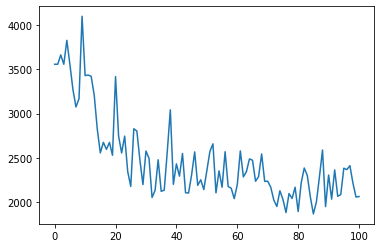

In [24]:
plt.plot(best_fitnesses)